# Groupe 3 : Projet Machine Learning

## Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk

In [2]:
dataset = pd.read_csv('scitweets_export.tsv', sep='\t')
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


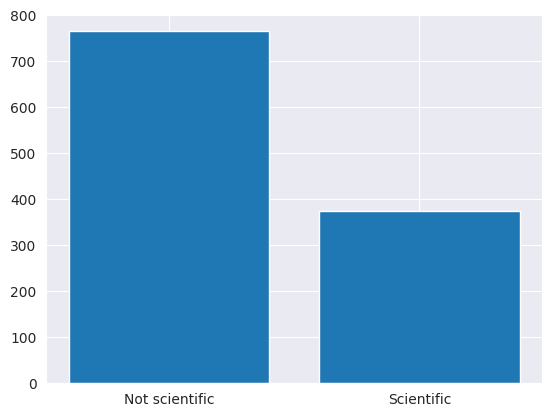

In [3]:
not_scientific = dataset.where(dataset['science_related'] == 0)
scientific = dataset.where(dataset['science_related'] == 1)

fig, ax = plt.subplots()
ax.bar(['Not scientific', 'Scientific'], [not_scientific['tweet_id'].count(), scientific['tweet_id'].count()])
plt.show()

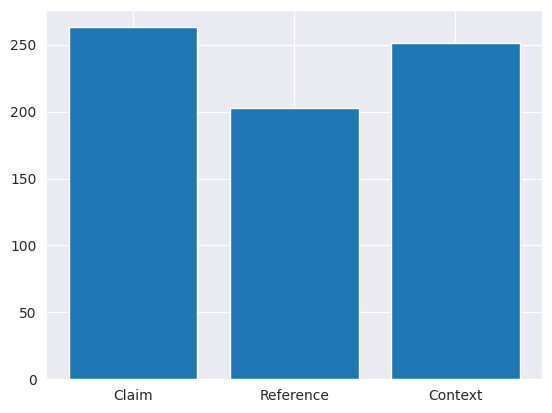

In [4]:
fig, ax = plt.subplots()
ax.bar(['Claim', "Reference", "Context"],
       [scientific.where(scientific['scientific_claim'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_reference'] == 1)['tweet_id'].count(),
        scientific.where(scientific['scientific_context'] == 1)['tweet_id'].count()])
plt.show()

## Prétraitement

On met tout en minuscule

In [5]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,can any gynecologist with cancer experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,does daily routine help prevent problems with ...,1,1.0,0.0,0.0


### Lemmatization

download the packages

In [6]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#

[nltk_data] Downloading package wordnet to /home/raphael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/raphael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raphael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove the stopwords but not the negation words or the words that are important for the sentiment analysis

In [7]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
work_to_keep = ['no', 'not', 'nor', 'too', 'very', 'against', 'but', 'don', 'don\'t', 'ain', 'aren', 'aren\'t', 'couldn', 'couldn\'t', 'didn', 'didn\'t', 'doesn', 'doesn\'t', 'hadn', 'hadn\'t', 'hasn', 'hasn\'t', 'haven', 'haven\'t', 'isn', 'isn\'t', 'mightn', 'mightn\'t', 'mustn', 'mustn\'t', 'needn', 'needn\'t', 'shan', 'shan\'t', 'shouldn', 'shouldn\'t', 'wasn', 'wasn\'t', 'weren', 'weren\'t', 'won', 'won\'t', 'wouldn', 'wouldn\'t']

for word in work_to_keep:
    stop_words.remove(word)

dataset['text'] = dataset['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove the links

In [8]:
for index, line in dataset.iterrows():
    splitted = line['text'].split(' ')
    new_text = []
    for word in splitted:
        if 'http' in word or 'www' in word:
            continue
        new_text.append(word)
    dataset.at[index, 'text'] = ' '.join(new_text)

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Transform the emojis into text

In [9]:
import emoji

# Parcourir les indices et modifier directement les valeurs dans le DataFrame
for index, line in dataset.iterrows():
    dataset.at[index, 'text'] = emoji.demojize(line['text'])

# Afficher les premières lignes du DataFrame pour vérifier les modifications
dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore. guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym :basketball::fle...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch-lock highs lead sleeping couch. gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove the non-alphabetic characters except the #

In [10]:
for index, line in dataset.iterrows():
    splitted = line['text'].split(' ')
    new_text = []
    for word in splitted:
        new_word = ""
        for l in word:
            if l.isalpha() or l in ['#', "'", '?', '!'] :
                new_word += l
            else:
                new_word += ' '
        new_text.append(new_word)
    dataset.at[index, 'text'] = ' '.join(new_text)

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess that's sign recent tread...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym basketball fle...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch lock highs lead sleeping couch gotta st...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Remove multiple spaces

In [11]:
for index, line in dataset.iterrows():
    dataset.at[index, 'text'] = ' '.join(line['text'].split())

dataset.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess that's sign recent treadm...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonald's breakfast stop gym basketball flexe...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couch lock highs lead sleeping couch gotta sto...,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


In [12]:
### import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import contractions
import enchant
from enchant.checker import SpellChecker

# Charger le modèle de langue anglaise de spaCy
nlp = spacy.load('en_core_web_sm')

# Initialiser le correcteur orthographique avec enchant
d = enchant.Dict("en_US")

def correct_spelling(text):
    """Corrige les fautes d'orthographe avec enchant."""
    checker = SpellChecker("en_US")
    checker.set_text(text)
    for error in checker:
        if error.suggest():  # S'il y a des suggestions
            error.replace(error.suggest()[0])  # Remplace par la première suggestion
    return checker.get_text()

def lemmatize_text(text):
    """Pipeline de prétraitement : Correction → Contractions → Lemmatisation."""
    # Étape 1: Correction orthographique
    text = correct_spelling(text)

    # Étape 2: Gestion des contractions (ex: "that's" → "that is")
    text = contractions.fix(text)

    # Étape 3: Remplacement manuel des 's résiduels (optionnel)
    text = text.replace("'s", " be")

    # Étape 4: Lemmatisation avec spaCy
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Appliquer la lemmatisation à la colonne 'text'
dataset['text_lemmatized'] = dataset['text'].apply(lemmatize_text)

# Afficher les résultats
print("Avant la lemmatisation :")
print(dataset['text'].head())
print("\nAprès la lemmatisation :")
print(dataset['text_lemmatized'].head())


Avant la lemmatisation :
0    knees bit sore guess that's sign recent treadm...
1    mcdonald's breakfast stop gym basketball flexe...
2    gynecologist cancer experience explain dangers...
3    couch lock highs lead sleeping couch gotta sto...
4    daily routine help prevent problems bipolar di...
Name: text, dtype: object

Après la lemmatisation :
0    knee bit sore guess that be sign recent tread ...
1    McDonald be breakfast stop gym basketball flex...
2    gynecologist cancer experience explain danger ...
3    couch lock high lead sleep couch get to stop shit
4    daily routine help prevent problem bipolar dis...
Name: text_lemmatized, dtype: object


## Vectorisation des textes

(TF-IDF)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Diviser les données en ensembles d'entraînement et de test
X = dataset['text']  # Utiliser uniquement la colonne 'text' comme feature
y_binary = dataset['science_related']  # Étiquette binaire (scientifique ou non)

# Diviser les données AVANT la vectorisation
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Vectorisation : apprendre le vocabulaire et les poids TF-IDF uniquement sur les données d'entraînement
vectorizer = TfidfVectorizer(max_features=100000)
X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement

# Appliquer la transformation aux données de test (sans réapprendre)
X_test_vec = vectorizer.transform(X_test)

TFID

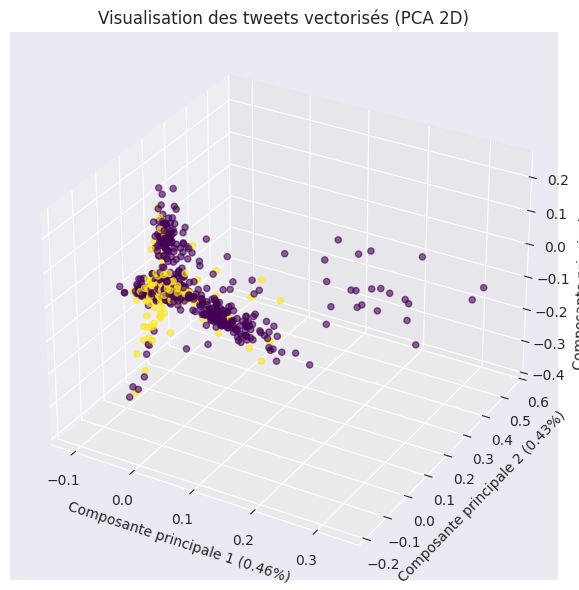

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduire la dimension à 2D avec PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_vec.toarray())  # Convertir la matrice creuse en tableau dense

# Visualiser les données en 2D
ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.6)
#plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (PCA 2D)')
ax.set_xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
ax.set_ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
ax.set_zlabel(f'Composante principale 3 ({pca.explained_variance_ratio_[2] * 100:.2f})')
plt.tight_layout()
plt.show()

TSNE

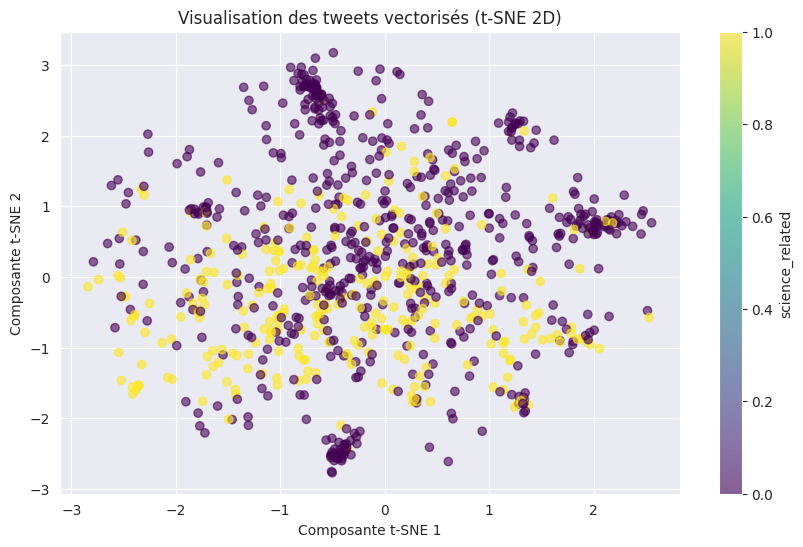

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduire la dimension à 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_vec.toarray())

# Visualiser les données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (t-SNE 2D)')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.show()

## Choix des modèles